## Importing libraries

In [126]:
# libraries
from __future__ import print_function, division
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

import BayesianLayers
from compression import compute_compression_rate, compute_reduced_weights
from utils import visualize_pixel_importance, generate_gif, visualise_weights

import os, sys
import itertools
from scipy import linalg
import matplotlib as mpl
!pip install pyomo
!pip install pypsa
!pip install pandapower
import pypsa
import pandapower as pp
import pandapower.networks as pn
from pandapower.estimation import estimate
import random as rand
import pandas as pd
from sklearn import mixture
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
sns.set()
rand.seed(2020)
tf.random.set_seed(2020)
torch.manual_seed(2020)

In [127]:
from data_preprocessing import extract_consumption_values
from bic import bic_criterion_gmm
from define_network import define_network
from generate_samples import generate_samples
from compress_model import compress_model

## Defining parameters

### Obs: case_14s and case_57 correspond to the IEEE standard test cases. case_3 corresponds to the 3-bus minimal example network on PyPSA, while opf_storage_hvdc corresponds to the PyPSA opf_storage_hvdc example.

In [128]:
net_case = "case_3" # Select ['case_14s', 'case_57', 'case_3', 'opf_storage_hvdc']
N = 60000.  # number of data points in the training set
n_of_network_samples = 100
n_of_gaussians = 5
train_frac = 0.8
percent_of_measurements = 0.4
estimation_method = 'bad_data_removal' # Select ['standard','bad_data_removal']
layer_proportions = [20,10]
net_type = 'case_3' # Select ['pp','case_3', 'opf_storage_hvdc'] pp is for pandapower cases 14s and 57

In [129]:
os.makedirs("./plots/", exist_ok=True)

## Fitting Solar and Normal data separately with Gaussian Mixture
#### Initially, a GMM with 3 components will be fitted, like in the original paper. Later, other pdfs will be tested.

In [130]:
os.system("unzip electricity_data.zip")
base_path = "./electricity_data/"

train_data_path = base_path + "2011-2012 Solar home electricity data v2.csv"
test_data_path = base_path + "2012-2013 Solar home electricity data v2.csv"

In [131]:
train_data = pd.read_csv(train_data_path, skiprows=1)
test_data = pd.read_csv(test_data_path, skiprows=1)

### GC = General Consumption for electricity supplied all the time (primary tariff, either inclining block or time of use rates), excluding solar generation and controlled load supply 
### CL = Controlled Load Consumption (Off peak 1 or 2 tariffs)
### GG = Gross Generation for electricity generated by the solar system with a gross metering configuration, measured separately to household loads

In [132]:
test_data.tail()

,Customer,Generator Capacity,Postcode,Consumption Category,date,0:30,1:00,1:30,2:00,2:30,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,Row Quality
268552,300,3.36,2086,GC,29/06/2013,0.171,0.832,0.440,0.745,0.149,...,0.383,0.404,0.367,0.398,0.350,0.228,0.170,0.139,0.171,NaN
268553,300,3.36,2086,GG,29/06/2013,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN
268554,300,3.36,2086,CL,30/06/2013,2.501,2.475,2.491,2.508,2.490,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.468,NaN
268555,300,3.36,2086,GC,30/06/2013,0.150,0.158,0.157,0.137,0.163,...,0.625,0.595,0.695,0.646,0.581,0.458,0.472,0.732,0.297,NaN
268556,300,3.36,2086,GG,30/06/2013,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,NaN


In [133]:
train_data_general, train_data_solar = extract_consumption_values(train_data)
test_data_general, test_data_solar = extract_consumption_values(test_data)

In [134]:
train_values = np.reshape(train_data_general.values, (train_data_general.shape[0]*train_data_general.shape[1],1))
test_values = np.reshape(test_data_general.values, (test_data_general.shape[0]*test_data_general.shape[1],1))

In [82]:
bic_criterion_gmm(10, train_values, test_values)

KeyboardInterrupt: 

#### n_of_components=5 was initially chosen

In [135]:
gmm = mixture.GaussianMixture(n_components=n_of_gaussians)
#fit it to the data
gmm.fit(train_values)

GaussianMixture(n_components=5)

#### Solar consumption data was either 0 or NaN. We will only fit GMM on the General Consumption values.

## Generating samples from Network

In [136]:
net = define_network(net_case)

In [137]:
# from pandapower.plotting.plotly import simple_plotly, vlevel_plotly
# from pandapower.plotting import cmap_discrete, create_line_collection, draw_collections
# sns.set_style("darkgrid")
# plt.figure()
#vlevel_plotly(net)
#simple_plotly(net)
# fig, ax = plt.subplots()
# pp.plotting.simple_plot(net, ax=ax)
# plt.savefig("net_14.pdf")
# plt.show()
# plt.close()
#plt.
# plt.legend()
# plt.show()
# pp.plotting.to_html(net, "test.html")
#, on_map=True)#, projection='epsg:31467')
# pc = pp.plotting.create_bus_collection(net)
# pp.plotting.draw_collections(pc)
#pp.plotting.simple_plot(net)#, on_map=True)
# net = pn.case57()#"generation") #mv_oberrhein("generation")

# cmap_list = [((0, 10), "green"), ((10, 30), "yellow"), ((30, 57), "red")]

# cmap, norm = cmap_discrete(cmap_list)

# lc = create_line_collection(net, cmap=cmap, norm=norm)

# draw_collections([lc])

In [138]:
# np.min(net.line['r_ohm_per_km'].values)
#net.line.loc[net.line.r_ohm_per_km == 0,'r_ohm_per_km'] = 10.0
#pp.diagnostic?
# net.line['r_ohm_per_km'].values
# np.random.choice(net.line.index, size=net.bus.shape[0])
# success_chi2 = pp.estimation.chi2_analysis(net, init="flat")

In [139]:
injection_values, network_state_samples, measurement_vector = generate_samples(net_case,n_of_network_samples,net, percent_of_measurements, estimation_method, gmm, net_type)

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.026109 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.026078 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025530 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.027921 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025578 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.027628 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.028666 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025721 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa

INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.026452 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025644 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.026289 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa.pf:Newton-Raphson solved in 3 iterations with error of 0.000000 in 0.025302 seconds
INFO:pypsa.pf:Performing non-linear load-flow on AC sub-network SubNetwork 0 for snapshots Index(['now'], dtype='object')
INFO:pypsa

## Fitting NN Model

In [140]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(layer_proportions[0]*measurement_vector.shape[1],input_dim=measurement_vector.shape[1]),
    tf.keras.layers.Dense(layer_proportions[1]*measurement_vector.shape[1], input_dim=layer_proportions[0]*measurement_vector.shape[1]),
    tf.keras.layers.Dense(network_state_samples.shape[1], input_dim=layer_proportions[1]*measurement_vector.shape[1]),
])

model.compile(
    loss='mse', # keras.losses.mean_squared_error
    optimizer=tf.keras.optimizers.SGD(lr=0.2),
)

print("Training ... With default parameters, this takes less than 10 seconds.")
training_history = model.fit(
    injection_values[:int(measurement_vector.shape[0]*train_frac)], # input
    network_state_samples[:int(measurement_vector.shape[0]*train_frac)], # output
    batch_size=int(measurement_vector.shape[0]*train_frac),
    verbose=0, # Suppress chatty output; use Tensorboard instead
    epochs=50,
    validation_data=(injection_values[int(measurement_vector.shape[0]*train_frac):], network_state_samples[int(measurement_vector.shape[0]*train_frac):]),
    callbacks=[tensorboard_callback],
)

print("Average test loss: ", np.average(training_history.history['loss']))


Training ... With default parameters, this takes less than 10 seconds.
Average test loss:  0.006506786050885599


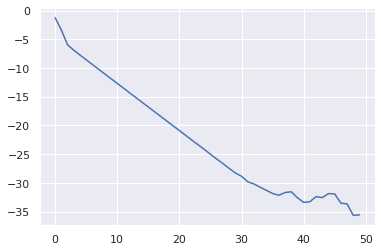

In [141]:
plt.plot(np.log(training_history.history['loss']))

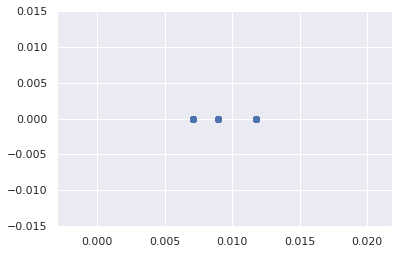

In [142]:
plt.scatter(model.predict(injection_values[-10:]),network_state_samples[-10:])

In [143]:
if __name__ == '__main__':

    class FLAGS:
        epochs=50
        batchsize=100
        thresholds=[-2.8, -3., -5.]
        
    FLAGS.cuda = torch.cuda.is_available()  # check if we can put the net on the GPU

    compress_model(injection_values, measurement_vector, train_frac, network_state_samples, layer_proportions, N, FLAGS)

torch.Size([80, 1, 1]) torch.Size([80, 3])
Epoch: 1 	Train loss: 0.03393575 	
Test loss: 0.00000739, Accuracy: 0/20 (0.00000000%)



/home/rafael/BCDL_SEEEDN/compress_model.py:134: UserWarning:

volatile was removed and now has no effect. Use `with torch.no_grad():` instead.

/home/rafael/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



Epoch: 2 	Train loss: 0.03388456 	
Test loss: 0.00002560, Accuracy: 0/20 (0.00000000%)

Epoch: 3 	Train loss: 0.03418333 	
Test loss: 0.00005133, Accuracy: 0/20 (0.00000000%)

Epoch: 4 	Train loss: 0.03336519 	
Test loss: 0.00008298, Accuracy: 0/20 (0.00000000%)

Epoch: 5 	Train loss: 0.03355255 	
Test loss: 0.00011574, Accuracy: 0/20 (0.00000000%)

Epoch: 6 	Train loss: 0.03305884 	
Test loss: 0.00014931, Accuracy: 0/20 (0.00000000%)

Epoch: 7 	Train loss: 0.03312145 	
Test loss: 0.00018781, Accuracy: 0/20 (0.00000000%)

Epoch: 8 	Train loss: 0.03273407 	
Test loss: 0.00022169, Accuracy: 0/20 (0.00000000%)

Epoch: 9 	Train loss: 0.03304304 	
Test loss: 0.00024894, Accuracy: 0/20 (0.00000000%)

Epoch: 10 	Train loss: 0.03276308 	
Test loss: 0.00026669, Accuracy: 0/20 (0.00000000%)

Epoch: 11 	Train loss: 0.03228983 	
Test loss: 0.00027784, Accuracy: 0/20 (0.00000000%)

Epoch: 12 	Train loss: 0.03227485 	
Test loss: 0.00028681, Accuracy: 0/20 (0.00000000%)

Epoch: 13 	Train loss: 0.0327